### Optimization Techniques
Methods to improve the accuracy or convergence time of an algorithm are:
* Removing Outliers


* Feature scaling.  It involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.  This will improve the time it takes to reach the optimal solution.


* Dimensionality reduction with "PCA" or applying "Feature Selection" techniques. This reduces the complexity of the model, ergo, allowing it to be visualized better. Also, this improves convergence time.


* Tune parameters for classifier. Any parameter provided when constructing a classifer may be optimized to improve accuracy of model. A validation curve can be constructed to determine the optimal value for a given parameter, http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve.


* Plot learning curves.  A learning curve displays if the algorithm is suffering from over-fitting, under-fitting, and if using more training examples will suffiently improve the algorithm's accuracy.


* Try different algorithms. For example, random forrest, svm, neural networks.

### Dependencies

In [1]:
from sklearn import svm # SVM classifier.
from sklearn.model_selection import GridSearchCV # Tuning hyper-parameters
from sklearn.preprocessing import StandardScaler # Feature scaling library.
import sqlite3 # Database library.
import os # Folder management library.
import pickle # Serializing module.
import numpy as np # Scientific computing library.
from sklearn.decomposition import PCA # Princliple Component Analysis library.

### Retrieve Data Sets

In [2]:
# Initializing database and cursor.
star_data_db = sqlite3.connect('star_data_sets_binary.db')
star_data_cursor = star_data_db.cursor()

sets = ['train_set', 'test_set', 'cv_set']
set_types = ['X', 'Y']

X_train, X_cv, X_test = [], [], []
y_train, y_cv, y_test = [], [], []

data_temp = []
for dset in sets:
    for set_type in set_types:
        star_data_cursor.execute('SELECT '+set_type+' FROM '+dset)
        for row in star_data_cursor.fetchall():
            # Deserializing features.
            data = pickle.loads(row[0])
            data_temp.append(data)

X_train = np.array(data_temp[0])
y_train = np.array(data_temp[1])

X_test = np.array(data_temp[2])
y_test = np.array(data_temp[3])

X_cv = np.array(data_temp[4])
y_cv = np.array(data_temp[5])

print('Done.')

Done.


### Merging Train and CV Sets

In [3]:
print(X_train.shape, X_cv.shape)

X_train = np.concatenate((X_train, X_cv), axis=0)
y_train = np.concatenate((y_train, y_cv), axis=0)

print(X_train.shape, y_train.shape)

(6460, 64) (1750, 64)
(8210, 64) (8210,)


### Feature Scaling
This will center the data for each feature by substracting the mean, and normalize it by dividing by the standard deviation (std).


Note: the mean and std of the training set is used and NOT the test set as to not give information to the classifier about the test set.

In [4]:
# Get mean and std of training set.
scaler = StandardScaler()
scaler.fit(X_train)

# Scale features of train and test sets using mean and std of train set.
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

print('Done')

Done


### Princliple Component Analysis (PCA)

In [5]:
pca = PCA(n_components=45)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_), 'This is the amount of variation maintained with pca.')

print(X_train_pca.shape, X_test_pca.shape)
print(X_train.shape, X_test.shape)


[ 0.23006712  0.15147351  0.08826337  0.04749942  0.03860944  0.03361408
  0.03271432  0.03207277  0.02670192  0.025434    0.02370931  0.01988179
  0.01775753  0.01733378  0.01645239  0.0150845   0.01453639  0.01271508
  0.01243047  0.01021728  0.00960474  0.00851092  0.00836001  0.00826033
  0.00815477  0.00806977  0.0077605   0.00750367  0.00688999  0.00588819
  0.00568852  0.00514318  0.00486478  0.00401594  0.00384809  0.00344574
  0.0032855   0.00323529  0.00288198  0.00270744  0.00220571  0.00185195
  0.00176399  0.00171797  0.00147593]
0.993703349217 This is the amount of variation maintained with pca.
(8210, 45) (1870, 45)
(8210, 64) (1870, 64)


In [29]:
# Temproary For fun SVM

clf = svm.SVC(kernel='rbf', degree=10, C=100, cache_size=14000, gamma=0.01)
clf.fit(X_train_pca, y_train)

with open('svm_tune_v1_temp.pickle', 'wb') as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

print(clf.score(X_test_pca, y_test))
print(clf.score(X_test_pca[1760:], y_test[1760:]))
print(clf.score(X_train_pca, y_train))

0.975935828877
0.681818181818
0.993422655298


In [ ]:
from sklearn.ensemble import RandomForestClassifier # Random forrest classifier.

clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
clf.fit(X_train_pca, y_train)

print(clf.score(X_test_pca, y_test))
print(clf.score(X_test_pca[1760:], y_test[1760:]))


### Tuning Hyper-Parameters for Classifier
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.


Hyper-parameters can be choses by searching the Hyper-parameter space for the best cross validation score using GridSearchCV http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.

In [6]:
print('Start')
# Parameters combinations to be tested.
parameters = {'C': [1, 10, 100, 1000],
              'kernel':['rbf', 'poly'], 
              'degree': [3, 4, 5], 
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

print(clf.best_estimator_)

with open('svm_tune_v1.pickle', 'wb') as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

print('Done')

Start
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Done


In [20]:
# with open('svm_tune_v1.pickle', 'rb') as f:
#     clf = pickle.loads(f)

# clf = svm.SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)
#---------------------------------------------------------------------------------------------
# print('Start')
# # Parameters combinations to be tested.
# parameters = {'C': [1, 10, 100, 1000],
#               'kernel':['rbf', 'poly', 'linear'], 
#               'degree': [3, 4, 5], 
#               'gamma': [0.001, 0.01, 0.1, 1, 10], 
#               'class_weight': [{0:.07, 1:.93}]}

# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters, n_jobs=-1)
# clf.fit(X_train_pca, y_train)

# print(clf.best_estimator_)
#------------------------------------------------------------------------------------------------
clf = svm.SVC(C = 100, gamma=0.1, kernel='rbf', class_weight = {0:.01, 1:.99})
clf.fit(X_train_pca, y_train)

#clf_pickle = open('svm_tune_v3.pkl', 'wb')
#pickle.dump(clf, clf_pickle)
#clf_pickle.close()


print(clf.score(X_test_pca, y_test))
print(clf.score(X_test_pca[:1760], y_test[:1760]), 'not t2cep')
print(clf.score(X_test_pca[1760:], y_test[1760:]), 't2cep')
print(clf.score(X_train_pca, y_train))
print(clf.predict(X_test_pca[1760:]), ' \n', y_test[1760:])

0.967914438503
0.995454545455 not t2cep
0.527272727273 t2cep
0.999269183922
[1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1
 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0]  
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [14]:
clf_unpickle = open('svm_tune_v2.pkl', 'rb')
 
# load the unpickle object into a variable
clf_disk = pickle.load(clf_unpickle)

print(clf_disk.score(X_test_pca, y_test))
print(clf_disk.score(X_test_pca[:1760], y_test[:1760]), 'not t2cep')
print(clf_disk.score(X_test_pca[1760:], y_test[1760:]), 't2cep')
print(clf_disk.score(X_train_pca, y_train))
print(clf_disk.predict(X_test_pca[1760:]), ' \n', y_test[1760:])

0.934759358289
0.940909090909 not t2cep
0.836363636364 t2cep
0.951766138855
[1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]  
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Learning Curve + Classifier

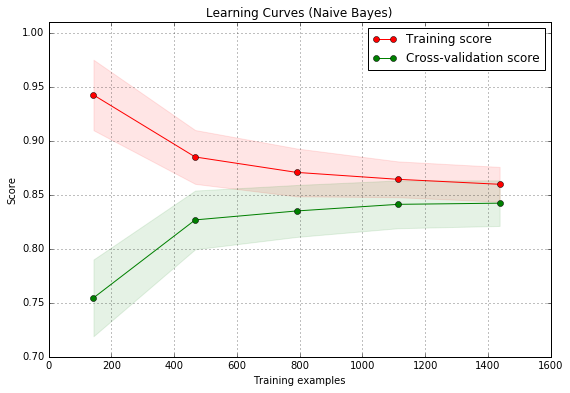

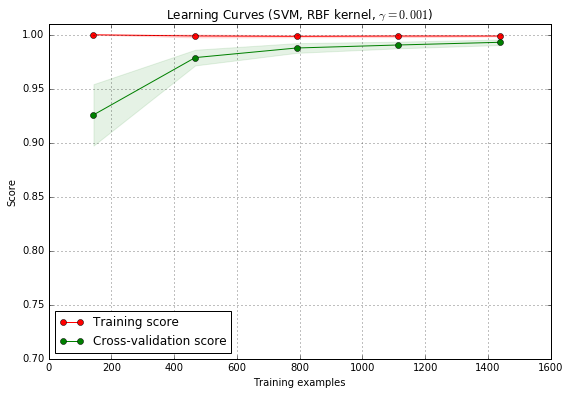

In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt # Plotting library.
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(9,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

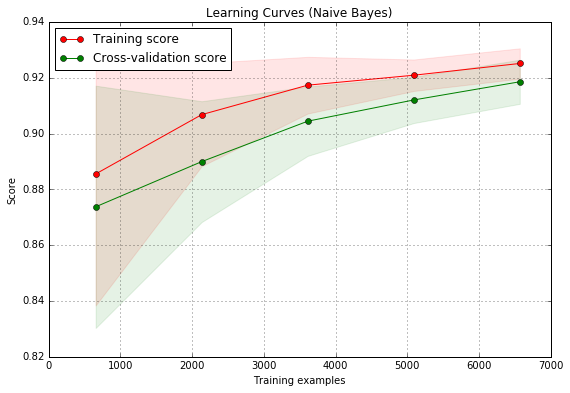

In [18]:
from sklearn.ensemble import RandomForestClassifier # Random forrest classifier.
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = svm.SVC(class_weight = {0:.1, 1:.9})
#estimator = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# estimator = clf = svm.SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

plot_learning_curve(estimator, title, X_train_pca, y_train, cv=cv, n_jobs=4)

# title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

### Precision and Recall